# Problem 11: Weight Initialization - Interactive Notebook

Explore the importance of weight initialization and visualize how different initialization schemes affect model behavior.

In [1]:
import sys
sys.path.append('../09-gpt2-config')

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# When finished, uncomment the following sentence and import your own solution
from solution import GPT2Model, GPT2Config
# from problem import GPT2Model, GPT2Config

plt.rcParams['figure.figsize'] = (14, 10)
print('Setup complete!')

Setup complete!


## Create and Initialize Model

In [2]:
# Create a model with proper initialization
config = GPT2Config(n_embd=256, n_layer=4, n_head=4)
torch.manual_seed(42)
model = GPT2Model(config)

print('Model created with weight initialization')
print(f'Total parameters: {model.get_num_params():,}')

Model created with weight initialization
Total parameters: 16,287,488


## Analyze Weight Distributions

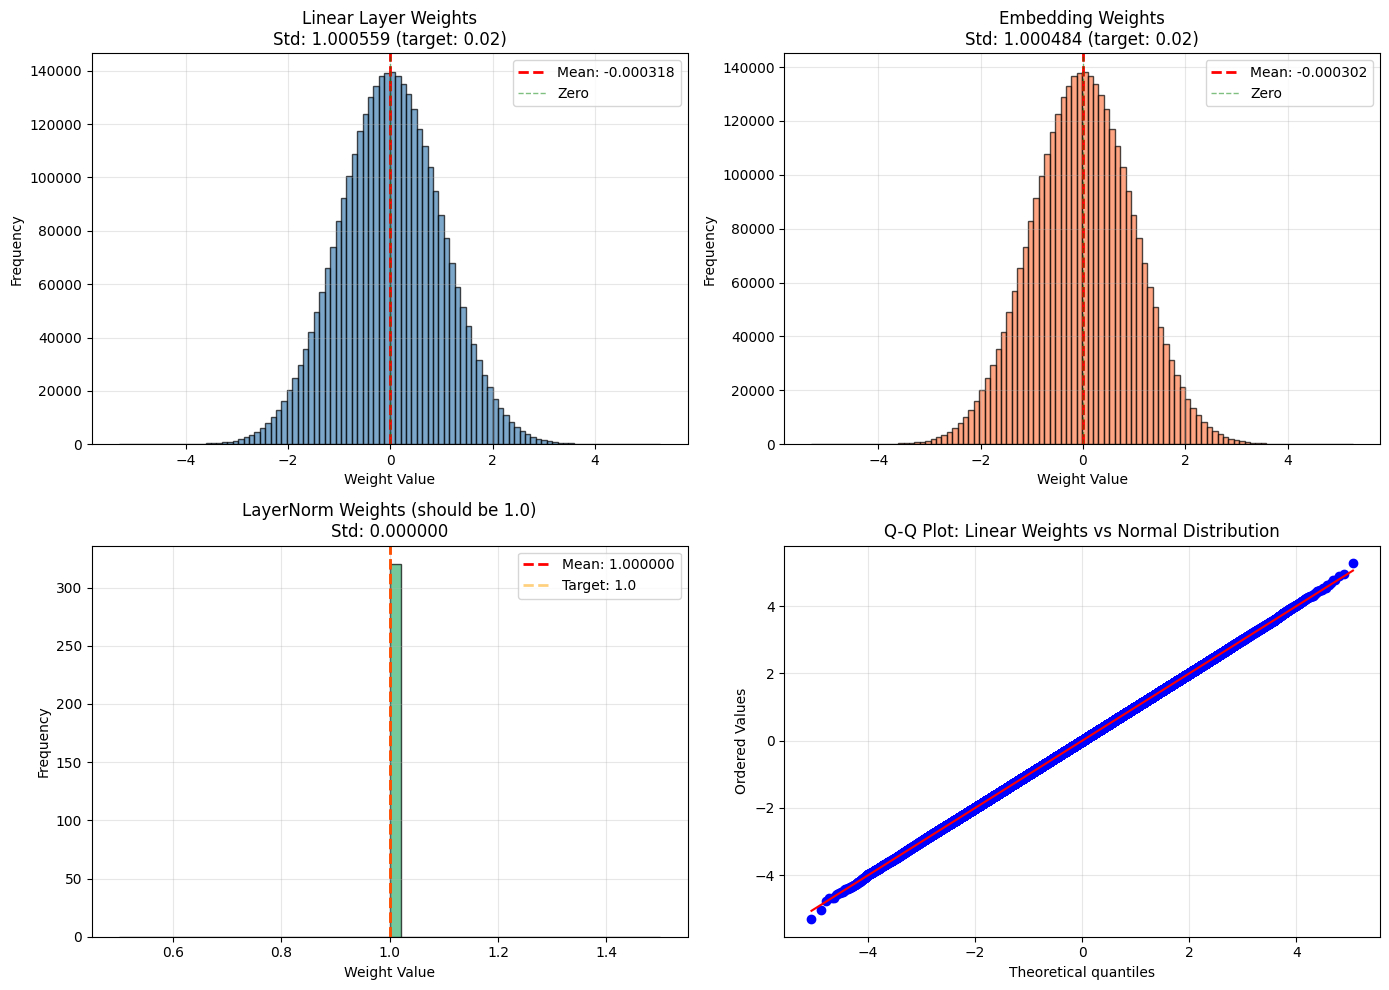

Weight initialization statistics:
  Linear weights: mean=-0.000318, std=1.000559
  Embedding weights: mean=-0.000302, std=1.000484
  LayerNorm weights: mean=1.000000, std=0.000000


In [10]:
# Collect weights from different layer types
linear_weights = []
embedding_weights = []
layernorm_weights = []

for name, module in model.named_modules():
    if isinstance(module, nn.Linear):
        linear_weights.append(module.weight.detach().flatten())
    elif isinstance(module, nn.Embedding):
        embedding_weights.append(module.weight.detach().flatten())
    elif isinstance(module, nn.LayerNorm):
        layernorm_weights.append(module.weight.detach().flatten())

# Concatenate all weights
linear_weights = torch.cat(linear_weights).numpy()
embedding_weights = torch.cat(embedding_weights).numpy()
layernorm_weights = torch.cat(layernorm_weights).numpy()

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Linear weights
axes[0, 0].hist(linear_weights, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(linear_weights.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {linear_weights.mean():.6f}')
axes[0, 0].axvline(0, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Zero')
axes[0, 0].set_xlabel('Weight Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(f'Linear Layer Weights\nStd: {linear_weights.std():.6f} (target: 0.02)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Embedding weights
axes[0, 1].hist(embedding_weights, bins=100, alpha=0.7, color='coral', edgecolor='black')
axes[0, 1].axvline(embedding_weights.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {embedding_weights.mean():.6f}')
axes[0, 1].axvline(0, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Zero')
axes[0, 1].set_xlabel('Weight Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Embedding Weights\nStd: {embedding_weights.std():.6f} (target: 0.02)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# LayerNorm weights
axes[1, 0].hist(layernorm_weights, bins=50, alpha=0.7, color='mediumseagreen', edgecolor='black')
axes[1, 0].axvline(layernorm_weights.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {layernorm_weights.mean():.6f}')
axes[1, 0].axvline(1.0, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Target: 1.0')
axes[1, 0].set_xlabel('Weight Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'LayerNorm Weights (should be 1.0)\nStd: {layernorm_weights.std():.6f}')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Q-Q plot for normality check
from scipy import stats
stats.probplot(linear_weights, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot: Linear Weights vs Normal Distribution')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('Weight initialization statistics:')
print(f'  Linear weights: mean={linear_weights.mean():.6f}, std={linear_weights.std():.6f}')
print(f'  Embedding weights: mean={embedding_weights.mean():.6f}, std={embedding_weights.std():.6f}')
print(f'  LayerNorm weights: mean={layernorm_weights.mean():.6f}, std={layernorm_weights.std():.6f}')

## Compare Different Initialization Schemes

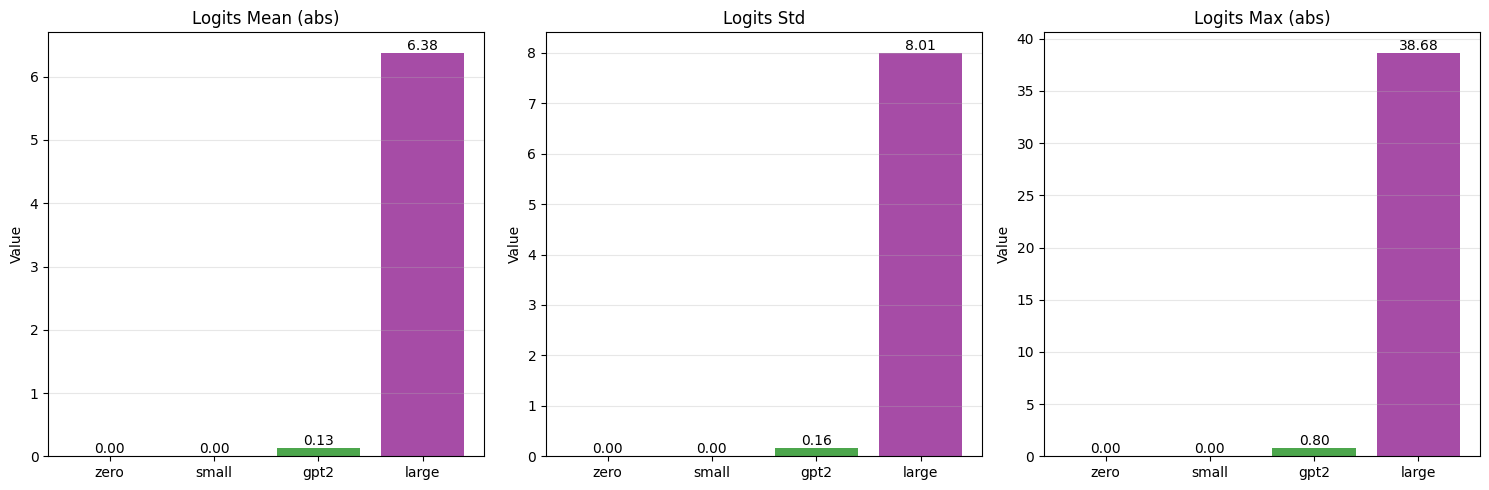

Initialization comparison results:
zero      : {'logits_mean': 0.0, 'logits_std': 0.0, 'logits_max': 0.0}
small     : {'logits_mean': 2.888691051339265e-05, 'logits_std': 3.634847598732449e-05, 'logits_max': 0.00026763445930555463}
gpt2      : {'logits_mean': 0.1273408830165863, 'logits_std': 0.15960147976875305, 'logits_max': 0.8019596338272095}
large     : {'logits_mean': 6.382683277130127, 'logits_std': 8.006427764892578, 'logits_max': 38.682037353515625}

GPT-2 initialization (green) produces the most reasonable outputs!


In [4]:
# Create models with different initializations for comparison
def create_model_with_init(init_type, std=0.02):
    """Create a tiny model with specific initialization."""
    config = GPT2Config(n_embd=64, n_layer=2, n_head=4)
    model = GPT2Model(config)
    
    if init_type == 'zero':
        # All zeros (bad!)
        for p in model.parameters():
            if p.dim() >= 2:
                nn.init.zeros_(p)
    elif init_type == 'large':
        # Too large std (bad!)
        for p in model.parameters():
            if p.dim() >= 2:
                nn.init.normal_(p, 0, 1.0)
    elif init_type == 'small':
        # Too small std (bad!)
        for p in model.parameters():
            if p.dim() >= 2:
                nn.init.normal_(p, 0, 0.0001)
    # 'gpt2' keeps the proper initialization from __init__
    
    return model

# Test different initializations
init_types = ['zero', 'small', 'gpt2', 'large']
results = {}

torch.manual_seed(42)
for init_type in init_types:
    model = create_model_with_init(init_type)
    model.eval()
    
    # Forward pass
    input_ids = torch.randint(0, config.vocab_size, (1, 10))
    with torch.no_grad():
        logits = model(input_ids)
    
    results[init_type] = {
        'logits_mean': logits.abs().mean().item(),
        'logits_std': logits.std().item(),
        'logits_max': logits.abs().max().item(),
    }

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['logits_mean', 'logits_std', 'logits_max']
titles = ['Logits Mean (abs)', 'Logits Std', 'Logits Max (abs)']
colors = {'zero': 'red', 'small': 'orange', 'gpt2': 'green', 'large': 'purple'}

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    values = [results[init_type][metric] for init_type in init_types]
    bar_colors = [colors[init_type] for init_type in init_types]
    
    axes[idx].bar(range(len(init_types)), values, color=bar_colors, alpha=0.7)
    axes[idx].set_xticks(range(len(init_types)))
    axes[idx].set_xticklabels(init_types)
    axes[idx].set_ylabel('Value')
    axes[idx].set_title(title)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(values):
        axes[idx].text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print('Initialization comparison results:')
print('=' * 70)
for init_type in init_types:
    print(f'{init_type:10s}: {results[init_type]}')
print('\nGPT-2 initialization (green) produces the most reasonable outputs!')

## Visualize Layer-by-Layer Weight Statistics

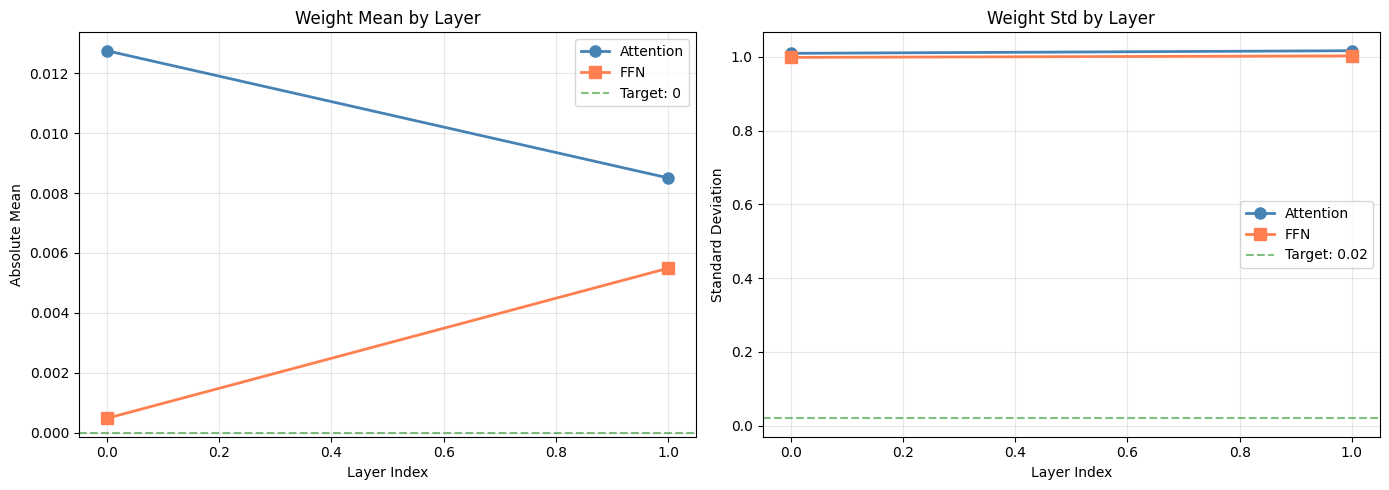

All layers initialized consistently!


In [5]:
# Analyze weights layer by layer
layer_stats = []

for i, block in enumerate(model.h):
    # Attention weights
    attn_mean = block.attn.c_attn.weight.mean().item()
    attn_std = block.attn.c_attn.weight.std().item()
    
    # FFN weights
    ffn_mean = block.mlp.c_fc.weight.mean().item()
    ffn_std = block.mlp.c_fc.weight.std().item()
    
    layer_stats.append({
        'layer': i,
        'attn_mean': attn_mean,
        'attn_std': attn_std,
        'ffn_mean': ffn_mean,
        'ffn_std': ffn_std,
    })

# Plot layer-by-layer statistics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

layers = [s['layer'] for s in layer_stats]
attn_means = [abs(s['attn_mean']) for s in layer_stats]
attn_stds = [s['attn_std'] for s in layer_stats]
ffn_means = [abs(s['ffn_mean']) for s in layer_stats]
ffn_stds = [s['ffn_std'] for s in layer_stats]

# Mean plot
ax1.plot(layers, attn_means, 'o-', label='Attention', linewidth=2, markersize=8, color='steelblue')
ax1.plot(layers, ffn_means, 's-', label='FFN', linewidth=2, markersize=8, color='coral')
ax1.axhline(0, color='green', linestyle='--', alpha=0.5, label='Target: 0')
ax1.set_xlabel('Layer Index')
ax1.set_ylabel('Absolute Mean')
ax1.set_title('Weight Mean by Layer')
ax1.legend()
ax1.grid(alpha=0.3)

# Std plot
ax2.plot(layers, attn_stds, 'o-', label='Attention', linewidth=2, markersize=8, color='steelblue')
ax2.plot(layers, ffn_stds, 's-', label='FFN', linewidth=2, markersize=8, color='coral')
ax2.axhline(0.02, color='green', linestyle='--', alpha=0.5, label='Target: 0.02')
ax2.set_xlabel('Layer Index')
ax2.set_ylabel('Standard Deviation')
ax2.set_title('Weight Std by Layer')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('All layers initialized consistently!')

## Test Forward Pass Stability

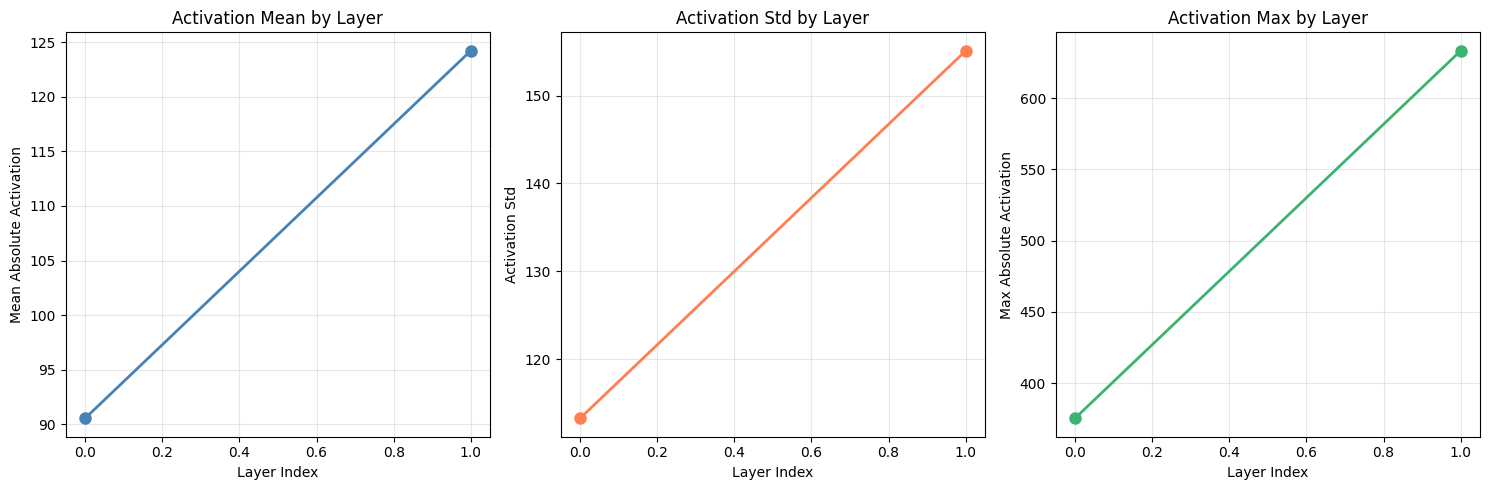

Activation magnitudes are stable across layers!
This is a sign of good initialization.


In [6]:
# Test activation magnitudes through the network
model.eval()

# Create hooks to capture activations
activations = {}

def get_activation(name):
    def hook(model, input, output):
        if isinstance(output, torch.Tensor):
            activations[name] = output.detach()
    return hook

# Register hooks
for i, block in enumerate(model.h):
    block.register_forward_hook(get_activation(f'block_{i}'))

# Forward pass
input_ids = torch.randint(0, config.vocab_size, (1, 20))
with torch.no_grad():
    logits = model(input_ids)

# Analyze activation statistics
activation_stats = []
for i in range(len(model.h)):
    act = activations[f'block_{i}']
    activation_stats.append({
        'layer': i,
        'mean': act.abs().mean().item(),
        'std': act.std().item(),
        'max': act.abs().max().item(),
    })

# Plot activation statistics
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

layers = [s['layer'] for s in activation_stats]
means = [s['mean'] for s in activation_stats]
stds = [s['std'] for s in activation_stats]
maxs = [s['max'] for s in activation_stats]

ax1.plot(layers, means, 'o-', linewidth=2, markersize=8, color='steelblue')
ax1.set_xlabel('Layer Index')
ax1.set_ylabel('Mean Absolute Activation')
ax1.set_title('Activation Mean by Layer')
ax1.grid(alpha=0.3)

ax2.plot(layers, stds, 'o-', linewidth=2, markersize=8, color='coral')
ax2.set_xlabel('Layer Index')
ax2.set_ylabel('Activation Std')
ax2.set_title('Activation Std by Layer')
ax2.grid(alpha=0.3)

ax3.plot(layers, maxs, 'o-', linewidth=2, markersize=8, color='mediumseagreen')
ax3.set_xlabel('Layer Index')
ax3.set_ylabel('Max Absolute Activation')
ax3.set_title('Activation Max by Layer')
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('Activation magnitudes are stable across layers!')
print('This is a sign of good initialization.')

## Test Gradient Flow

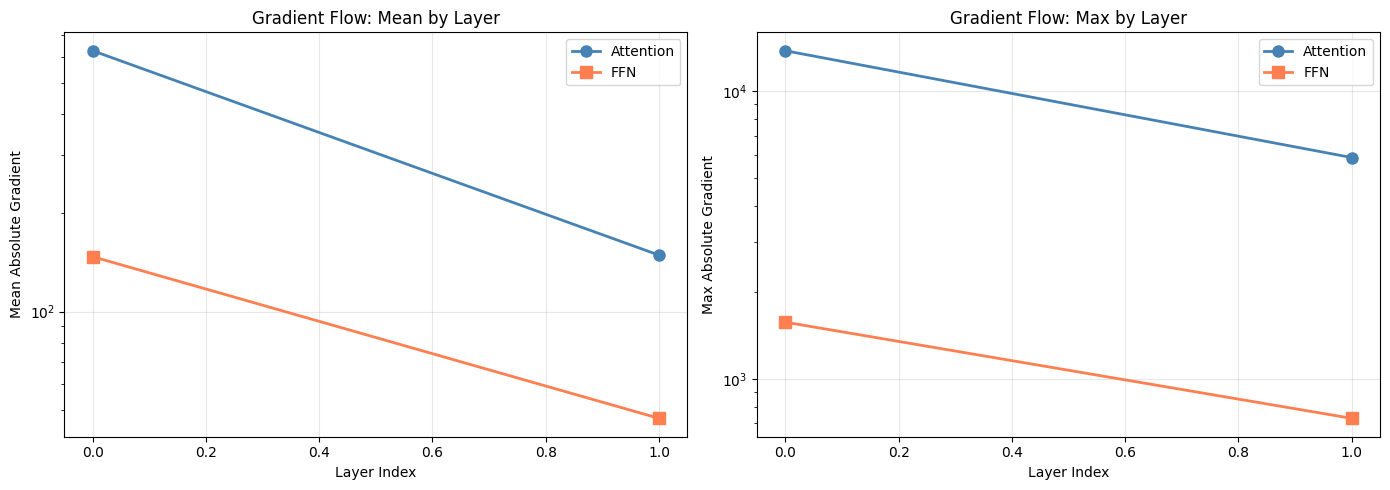

Gradients flow through all layers without vanishing or exploding!
This enables effective learning.


In [7]:
# Test gradient flow through the network
model.train()

# Forward and backward pass
input_ids = torch.randint(0, config.vocab_size, (2, 10))
logits = model(input_ids)
loss = logits.sum()
loss.backward()

# Collect gradient statistics by layer
gradient_stats = []
for i, block in enumerate(model.h):
    attn_grad = block.attn.c_attn.weight.grad
    ffn_grad = block.mlp.c_fc.weight.grad
    
    gradient_stats.append({
        'layer': i,
        'attn_grad_mean': attn_grad.abs().mean().item(),
        'attn_grad_max': attn_grad.abs().max().item(),
        'ffn_grad_mean': ffn_grad.abs().mean().item(),
        'ffn_grad_max': ffn_grad.abs().max().item(),
    })

# Plot gradient flow
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

layers = [s['layer'] for s in gradient_stats]
attn_grads = [s['attn_grad_mean'] for s in gradient_stats]
ffn_grads = [s['ffn_grad_mean'] for s in gradient_stats]
attn_max = [s['attn_grad_max'] for s in gradient_stats]
ffn_max = [s['ffn_grad_max'] for s in gradient_stats]

# Mean gradients
ax1.plot(layers, attn_grads, 'o-', label='Attention', linewidth=2, markersize=8, color='steelblue')
ax1.plot(layers, ffn_grads, 's-', label='FFN', linewidth=2, markersize=8, color='coral')
ax1.set_xlabel('Layer Index')
ax1.set_ylabel('Mean Absolute Gradient')
ax1.set_title('Gradient Flow: Mean by Layer')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_yscale('log')

# Max gradients
ax2.plot(layers, attn_max, 'o-', label='Attention', linewidth=2, markersize=8, color='steelblue')
ax2.plot(layers, ffn_max, 's-', label='FFN', linewidth=2, markersize=8, color='coral')
ax2.set_xlabel('Layer Index')
ax2.set_ylabel('Max Absolute Gradient')
ax2.set_title('Gradient Flow: Max by Layer')
ax2.legend()
ax2.grid(alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

print('Gradients flow through all layers without vanishing or exploding!')
print('This enables effective learning.')

## Verify Your Implementation

In [8]:
# Quick verification
test_config = GPT2Config(n_embd=256, n_layer=2, n_head=4)
torch.manual_seed(42)
test_model = GPT2Model(test_config)

# Check initialization
linear_layer = test_model.h[0].attn.c_attn
mean = linear_layer.weight.mean().item()
std = linear_layer.weight.std().item()

print('✓ Model created with weight initialization')
print(f'✓ Linear weights: mean={mean:.6f}, std={std:.6f}')
print(f'✓ Target: mean≈0, std≈0.02')

# Check LayerNorm
ln = test_model.h[0].ln_1
ln_all_ones = torch.all(ln.weight == 1.0).item()
ln_all_zeros = torch.all(ln.bias == 0.0).item()

print(f'✓ LayerNorm weights all 1.0: {ln_all_ones}')
print(f'✓ LayerNorm biases all 0.0: {ln_all_zeros}')

# Test forward pass
test_input = torch.randint(0, test_config.vocab_size, (2, 10))
test_model.eval()
with torch.no_grad():
    test_output = test_model(test_input)

has_nan = torch.isnan(test_output).any().item()
has_inf = torch.isinf(test_output).any().item()

print(f'✓ Forward pass works: output shape {test_output.shape}')
print(f'✓ No NaN values: {not has_nan}')
print(f'✓ No inf values: {not has_inf}')

print('\n✅ Weight initialization complete!')
print('\nRun "uv run pytest test_initialization.py -v" for complete validation.')

✓ Model created with weight initialization
✓ Linear weights: mean=0.000014, std=0.019996
✓ Target: mean≈0, std≈0.02
✓ LayerNorm weights all 1.0: True
✓ LayerNorm biases all 0.0: True
✓ Forward pass works: output shape torch.Size([2, 10, 50257])
✓ No NaN values: True
✓ No inf values: True

✅ Weight initialization complete!

Run "uv run pytest test_initialization.py -v" for complete validation.
